link github: https://github.com/kimvo646/NLP.git

# Cài đặt

## pip install

In [345]:
!pip install underthesea

In [346]:
!pip install gensim

In [347]:
!pip install tensorflow

## Thư viện

In [348]:
# Xử lý dữ liệu
import pandas as pd
import numpy as np
import string
import re
import nltk
from underthesea import sent_tokenize, word_tokenize
from itertools import chain
from collections import Counter
from joblib import load

# Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud

# Mô hình
## LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
## RandomForest
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
## LSTM
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Khác
import warnings
warnings.filterwarnings("ignore")

## input

In [349]:
link_train = 'https://raw.githubusercontent.com/kimvo646/NLP/main/train_data.csv'
train = pd.read_csv(link_train, sep='\t', encoding='utf-16')
train.head(10)

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,1,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",1,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",1,0
5,"giảng viên đảm bảo thời gian lên lớp , tích cự...",1,0
6,"thời lượng học quá dài , không đảm bảo tiếp th...",0,1
7,"nội dung môn học có phần thiếu trọng tâm , hầu...",0,1
8,cần nói rõ hơn bằng cách trình bày lên bảng th...,0,1
9,thầy rất tận tình và đi dạy rất đúng giờ .,1,0


In [350]:
link_test = 'https://raw.githubusercontent.com/kimvo646/NLP/main/test_data.csv'
test = pd.read_csv(link_test, sep='\t', encoding='utf-16')
test.head()

,sentence,sentiment,topic
0,nói tiếng anh lưu loát .,1,0
1,giáo viên rất vui tính .,1,0
2,cô max có tâm .,1,0
3,"giảng bài thu hút , dí dỏm .",1,0
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",0,0


In [351]:
link_valid = 'https://raw.githubusercontent.com/kimvo646/NLP/main/validation_data.csv'
valid = pd.read_csv(link_valid, sep='\t', encoding='utf-16')
valid.head()

,sentence,sentiment,topic
0,giáo trình chưa cụ thể .,0,1
1,giảng buồn ngủ .,0,0
2,"giáo viên vui tính , tận tâm .",1,0
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",0,0
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",0,0


# Tổng quan bộ dữ liệu

In [352]:
# Tổng số dòng, số cột của bộ dữ liệu
print ('Các cột hiện có của bộ dữ liệu:')
for x in train.columns:
  print('>', x)
print(f"Bộ dữ liệu bao gồm {train.shape[1]} cột và {train.shape[0]} dòng")

Các cột hiện có của bộ dữ liệu:
> sentence
> sentiment
> topic
Bộ dữ liệu bao gồm 3 cột và 10968 dòng


# Tiền xử lý

## Kiểm tra các giá trị bị thiếu

In [353]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10968 entries, 0 to 10967
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   10968 non-null  object
 1   sentiment  10968 non-null  int64 
 2   topic      10968 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 257.2+ KB


In [354]:
train.isna().sum()

sentence     0
sentiment    0
topic        0
dtype: int64

## Tách từ

In [355]:
def normalize_text(s):
    # Uncased
    s = s.lower()

    # Remove punctuations
    s = ''.join(ch for ch in s if ch not in string.punctuation)

    # Remove entities
    s = re.sub(r'\b((\w+|)wzjwz\d+)\b', " ", s)

    # Remove numbers
    s = re.sub(r'\d', ' ', s)

     # Fix whitespaces
    s = re.sub(r'\s+', ' ', s)

    #Remove leading and trailing spaces
    s = s.strip()

    return s

def tokenizer(text):
    tokens = []
    for sent in sent_tokenize(text):
        words = word_tokenize(sent)
        tokens.extend(words)
    return tokens


## Biểu diễn dữ liệu

In [356]:
df_label = train.copy()

# Thay đổi giá trị trong cột 'sentiment' của bản sao
df_label['sentiment'] = df_label['sentiment'].replace({
    0: 'negative',
    1: 'positive'})

df_label['topic'] = df_label['topic'].replace({
    0: 'lecturer',
    1: 'training_program',
    2: 'facility',
    3: 'others'
})

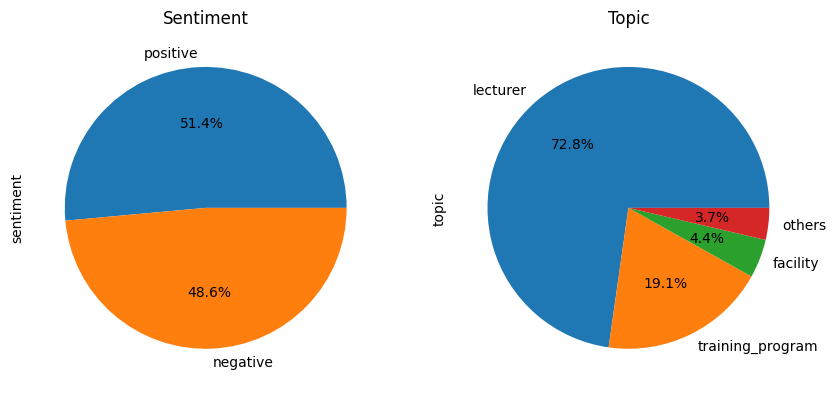

In [357]:
# Tạo figure và axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Vẽ biểu đồ pie cho cột 'sentiment'
df_label['sentiment'].value_counts().plot(kind='pie', ax=axs[0], autopct='%1.1f%%')
axs[0].set_title('Sentiment')

# Vẽ biểu đồ pie cho cột 'topic'
df_label['topic'].value_counts().plot(kind='pie', ax=axs[1], autopct='%1.1f%%')
axs[1].set_title('Topic')

# Hiển thị biểu đồ
plt.show()

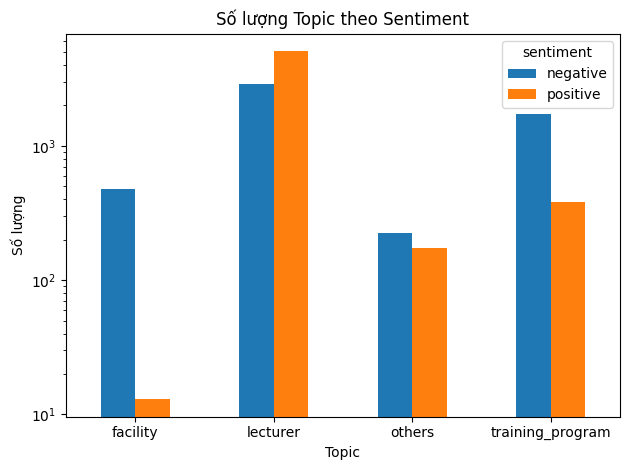

In [358]:
# Tạo bảng tần số chéo giữa 'sentiment' và 'topic'
cross_tab = pd.crosstab(df_label['topic'], df_label['sentiment'])

# Vẽ barchart
cross_tab.plot(kind='bar', label = 'sentiment')
plt.xticks(rotation = 0)
plt.ylabel('Số lượng')
plt.xlabel('Topic')
plt.title('Số lượng Topic theo Sentiment')
plt.yscale('log')
plt.tight_layout()
plt.show()

##Text mining

In [359]:
train_x=train['sentence'].tolist()
train_x=[normalize_text(sentence)for sentence in train_x]
all_tokens_train = [tokenizer(sentence) for sentence in train_x]

In [360]:
valid_x = valid['sentence'].tolist()
valid_x=[normalize_text(sentence)for sentence in valid_x]
all_tokens_valid = [tokenizer(sentence) for sentence in valid_x]

In [361]:
test_x = test['sentence'].tolist()
test_x=[normalize_text(sentence)for sentence in test_x]
all_tokens_test = [tokenizer(sentence) for sentence in test_x]


In [362]:
#Đếm từ
all_tokens=list(chain.from_iterable(all_tokens_train))
counter=Counter(all_tokens)
# all_tokens

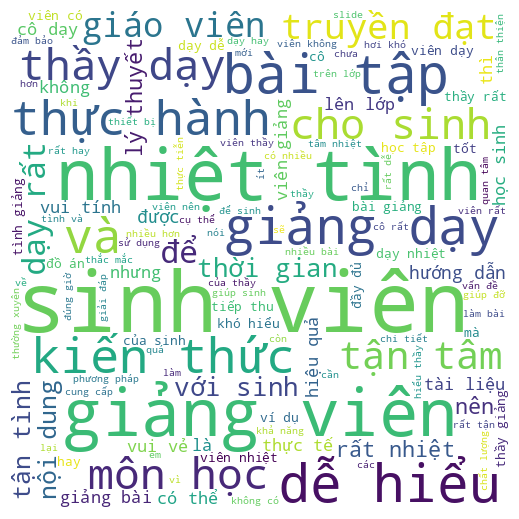

In [363]:
text = ' '.join(all_tokens)

# Tạo một đối tượng WordCloud
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Vẽ WordCloud
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Word2Vec
Nguồn tham khảo W2v: https://github.com/namlv97/biLSTM-vietnamese-uit-student-feedbacks/blob/main/biLSTM_Vietnamese_uit_student_feedbacks.ipynb

In [364]:
# Cài đặt các chỉ số
min_count=1
window=3
vector_size=300
alpha=1e-3
min_alpha=1e-4
negative=10

In [365]:
word_sents_train=[sent for sent in all_tokens_train]
# Tạo mô hình Word2Vec
w2v_model = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, alpha=alpha, min_alpha=min_alpha, negative=negative, sg=1)
# Xây dựng từ điển cho tập dữ liệu
w2v_model.build_vocab(word_sents_train)
#Huấn luyện mô hình
w2v_model.train(word_sents_train, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7298035, 10507100)

In [366]:
# Huấn luyện cho tập all_tokens_test
word_sents_test = [sent for sent in all_tokens_test]
w2v_model.build_vocab(word_sents_test, update=True)
w2v_model.train(word_sents_test, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

(1986437, 2863100)

In [367]:
# Huấn luyện cho tập all_tokens_valid
word_sents_valid = [sent for sent in all_tokens_valid]
w2v_model.build_vocab(word_sents_valid, update=True)
w2v_model.train(word_sents_valid, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

# Lưu mô hình sau khi huấn luyện
w2v_model.save("model_w2v")

# Huấn luyện mô hình

##Random Forest

In [368]:
def sentence_to_vec(sentence, model):
    vecs = [model.wv[word] for word in sentence if word in model.wv]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

###Topic

In [369]:

train_y=train['topic'].tolist()
test_y = test['topic'].tolist()

# Tạo ma trận đặc trưng cho tập huấn luyện và kiểm tra
X_train_w2v = np.array([sentence_to_vec(sent, w2v_model) for sent in word_sents_train])
X_test_w2v = np.array([sentence_to_vec(sent, w2v_model) for sent in word_sents_test])

# Tạo mô hình Decision Tree
classifier_topic = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện Word2Vec
classifier_topic.fit(X_train_w2v, train_y)

# Lưu mô hình
dump(classifier_topic, 'model_random_forest_topic.joblib')

# Dự đoán với dữ liệu kiểm tra
predicted_y = classifier_topic.predict(X_test_w2v)


In [370]:
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(test_y, predicted_y)
recall = recall_score(test_y, predicted_y, average='weighted')
precision = precision_score(test_y, predicted_y, average='weighted')
f1 = f1_score(test_y, predicted_y, average='weighted')

# In ra các chỉ số
print(f'Accuracy: {accuracy}')
print(f'Recall:   {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.8449483161053685
Recall:   0.8449483161053685
Precision: 0.8344108974046336
F1 Score: 0.834199309809798


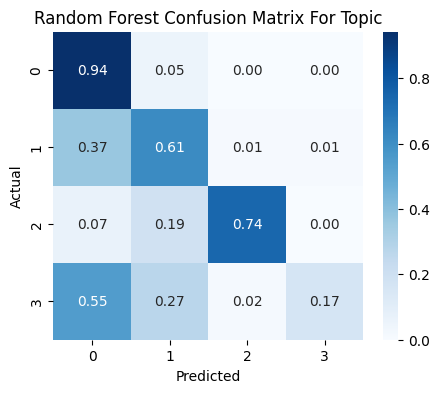

In [371]:
# Tạo và in ra ma trận nhầm lẫn
conf_mat = confusion_matrix(test_y, predicted_y)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix For Topic')
plt.show()


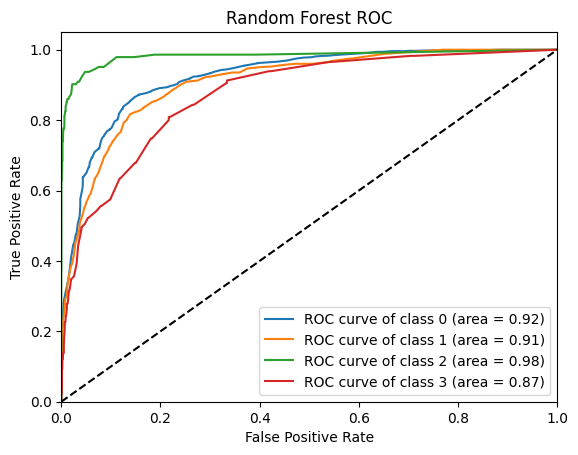

Macro-average AUC: 0.922203881786887
Micro-average AUC: 0.9703318171004576


In [372]:
# Binarize the output
train_y_bin = label_binarize(train_y, classes=np.unique(train_y))
test_y_bin = label_binarize(test_y, classes=np.unique(train_y))

# Compute the predicted probabilities
predicted_probs = classifier_topic.predict_proba(X_test_w2v)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(train_y))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

# Compute Macro-average AUC
macro_auc = roc_auc_score(test_y_bin, predicted_probs, multi_class='ovr', average='macro')
print('Macro-average AUC:', macro_auc)

# Compute Micro-average AUC
micro_auc = roc_auc_score(test_y_bin, predicted_probs, multi_class='ovr', average='micro')
print('Micro-average AUC:', micro_auc)

###Sentiment

In [373]:
train_y=train['sentiment'].tolist()
test_y = test['sentiment'].tolist()

# Tạo ma trận đặc trưng cho tập huấn luyện và kiểm tra
X_train_w2v = np.array([sentence_to_vec(sent, w2v_model) for sent in word_sents_train])
X_test_w2v = np.array([sentence_to_vec(sent, w2v_model) for sent in word_sents_test])

# Tạo mô hình Random Forest
classifier_sentiment = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện Word2Vec
classifier_sentiment.fit(X_train_w2v, train_y)

# Lưu mô hình
dump(classifier_sentiment, 'model_random_forest_sentiment.joblib')

# Dự đoán với dữ liệu kiểm tra
predicted_y = classifier_sentiment.predict(X_test_w2v)

In [374]:
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(test_y, predicted_y)
recall = recall_score(test_y, predicted_y, average='weighted')
precision = precision_score(test_y, predicted_y, average='weighted')
f1 = f1_score(test_y, predicted_y, average='weighted')

# In ra các chỉ số
print(f'Accuracy: {accuracy}')
print(f'Recall:   {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Accuracy: 0.8979659886628877
Recall:   0.8979659886628877
Precision: 0.9003902448073606
F1 Score: 0.8980562352647355


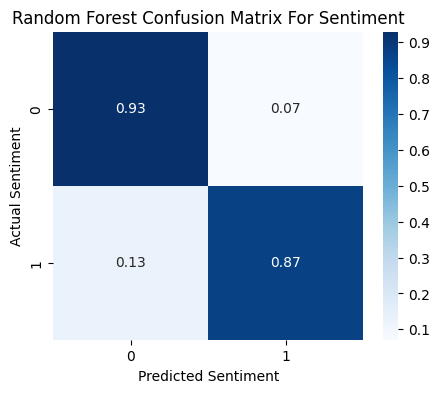

In [375]:
# Tạo và in ra ma trận nhầm lẫn
conf_mat = confusion_matrix(test_y, predicted_y)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Random Forest Confusion Matrix For Sentiment')
plt.show()


##Logistic Regression

### Topic

In [376]:
def get_sentence_vector(sentence, model):
    vector_sum = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector_sum += model.wv[word]
            count += 1
    if count != 0:
        return vector_sum / count
    else:
        return vector_sum

X_train_w2v = [get_sentence_vector(sentence, w2v_model) for sentence in all_tokens_train]
X_test_w2v = [get_sentence_vector(sentence, w2v_model) for sentence in all_tokens_test]

In [377]:
# Chia dữ liệu thành features và labels
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)

y_train_topic = train['topic']
y_test_topic = test['topic']

In [378]:
logistic_model_topic = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, random_state=42)
logistic_model_topic.fit(X_train_w2v, train['topic'])
pred_topic = logistic_model_topic.predict(X_test_w2v)

In [379]:
dump(logistic_model_topic, 'model_Logistic_Regression_topic.joblib')

['model_Logistic_Regression_topic.joblib']

In [380]:
accuracy = accuracy_score(y_test_topic, pred_topic)
precision = precision_score(y_test_topic, pred_topic, average='weighted')
recall = recall_score(y_test_topic, pred_topic, average='weighted')
f1 = f1_score(y_test_topic, pred_topic, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8512837612537513
Precision: 0.8414171335397487
Recall: 0.8512837612537513
F1 Score: 0.8401418294923361


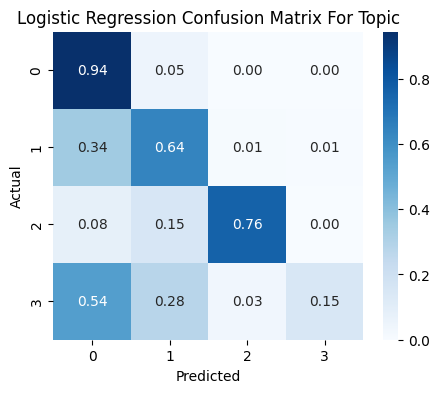

In [381]:
conf_mat = confusion_matrix(y_test_topic, pred_topic)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix For Topic')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Sentiment

In [382]:
X_train_w2v = [get_sentence_vector(sentence, w2v_model) for sentence in all_tokens_train]
X_test_w2v = [get_sentence_vector(sentence, w2v_model) for sentence in all_tokens_test]

# Chia dữ liệu thành features và labels
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)
# Chia dữ liệu thành features và labels cho topic
y_train_sentiment = train['sentiment']
y_test_sentiment = test['sentiment']

In [383]:
logistic_model_sentiment = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, random_state=42)
logistic_model_sentiment.fit(X_train_w2v, train['sentiment'])
pred_sentiment = logistic_model_sentiment.predict(X_test_w2v)

In [384]:
dump(logistic_model_sentiment, 'model_Logistic_Regression_sentiment.joblib')

['model_Logistic_Regression_sentiment.joblib']

In [385]:
accuracy = accuracy_score(y_test_sentiment, pred_sentiment)
precision = precision_score(y_test_sentiment, pred_sentiment, average='weighted')
recall = recall_score(y_test_sentiment, pred_sentiment, average='weighted')
f1 = f1_score(y_test_sentiment, pred_sentiment, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9033011003667889
Precision: 0.9046330291604036
Recall: 0.9033011003667889
F1 Score: 0.9033870025465424


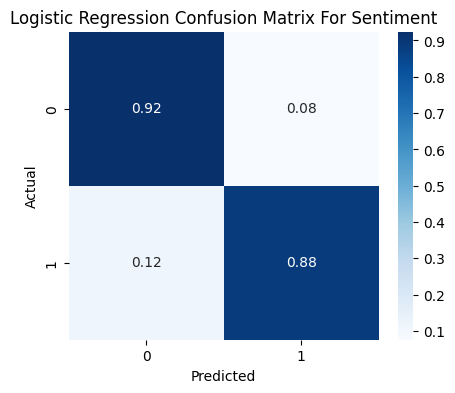

In [386]:
conf_mat = confusion_matrix(y_test_sentiment, pred_sentiment)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix For Sentiment')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LSTM

### Topic

In [387]:
# # Kích thước của từ điển
# vocab_size = len(w2v_model.wv.key_to_index) + 1

# Kích thước của vector nhúng
embedding_dim = w2v_model.vector_size

# Xây dựng mô hình LSTM
model_LSTM_topic = Sequential()
model_LSTM_topic.add(LSTM(units=100, return_sequences=True, input_shape=(1, embedding_dim)))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(Dense(units=4, activation="softmax"))

# Biên dịch mô hình
model_LSTM_topic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model_LSTM_topic.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 1, 100)            160400    
                                                                 
 dropout_56 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_57 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_57 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_58 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_58 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_59 (LSTM)              (None, 50)              

In [388]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        vec += model.wv.get_vector(word).reshape((1, model.vector_size))
        count += 1.
    if count != 0:
        vec /= count
    return vec

X_train = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_train])
X_valid = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_valid])


In [389]:
#xác định các tập để huấn luyện mô hình
y_train = to_categorical(train['topic'])

X_train = X_train.reshape(-1, 1, embedding_dim)
X_valid = X_valid.reshape(-1, 1, embedding_dim)


In [390]:
# Huấn luyện mô hình
model_LSTM_topic.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, to_categorical(valid['topic'])))

Epoch 1/20
343/343 [==============================] - 21s 36ms/step - loss: 0.6791 - accuracy: 0.7629 - val_loss: 0.5266 - val_accuracy: 0.8205
Epoch 2/20
343/343 [==============================] - 6s 17ms/step - loss: 0.5193 - accuracy: 0.8163 - val_loss: 0.5113 - val_accuracy: 0.7980
Epoch 3/20
343/343 [==============================] - 5s 14ms/step - loss: 0.4833 - accuracy: 0.8249 - val_loss: 0.4838 - val_accuracy: 0.8159
Epoch 4/20
343/343 [==============================] - 4s 13ms/step - loss: 0.4740 - accuracy: 0.8273 - val_loss: 0.4479 - val_accuracy: 0.8464
Epoch 5/20
343/343 [==============================] - 5s 16ms/step - loss: 0.4636 - accuracy: 0.8325 - val_loss: 0.4435 - val_accuracy: 0.8411
Epoch 6/20
343/343 [==============================] - 8s 23ms/step - loss: 0.4537 - accuracy: 0.8346 - val_loss: 0.4318 - val_accuracy: 0.8490
Epoch 7/20
343/343 [==============================] - 9s 27ms/step - loss: 0.4463 - accuracy: 0.8369 - val_loss: 0.4576 - val_accuracy: 0.829

In [391]:
model_LSTM_topic.save('model_LSTM_topic.h5')

In [392]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


94/94 [==============================] - 4s 7ms/step
Accuracy: 0.8472824274758253
Recall: 0.6473046248211057
Precision: 0.7431469145309364
F1 Score: 0.6452459800302058


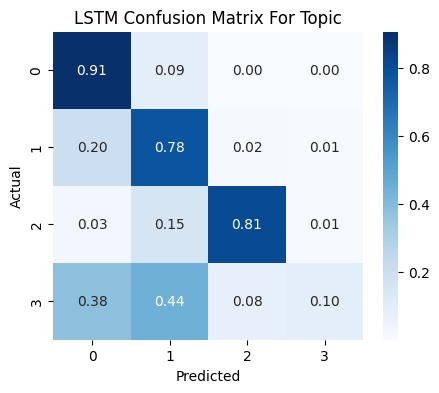

In [393]:
# Tạo và in ra confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix For Topic')
plt.show()

### Sentiment

In [394]:
# Xây dựng mô hình LSTM
model_LSTM_sentiment = Sequential()
model_LSTM_sentiment.add(LSTM(units=100, return_sequences=True, input_shape=(1, embedding_dim)))
model_LSTM_sentiment.add(Dropout(0.2))
model_LSTM_sentiment.add(LSTM(units=50, return_sequences=True))
model_LSTM_sentiment.add(Dropout(0.2))
model_LSTM_sentiment.add(LSTM(units=50, return_sequences=True))
model_LSTM_sentiment.add(Dropout(0.2))
model_LSTM_sentiment.add(LSTM(units=50))
model_LSTM_sentiment.add(Dropout(0.2))
model_LSTM_sentiment.add(Dense(units=2, activation="softmax"))

# Biên dịch mô hình
model_LSTM_sentiment.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model_LSTM_sentiment.summary())


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1, 100)            160400    
                                                                 
 dropout_60 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_61 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_61 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_62 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_62 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_63 (LSTM)              (None, 50)              

In [395]:
#xác định các tập để huấn luyện mô hình
y_train = to_categorical(train['sentiment'])

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM_sentiment.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, to_categorical(valid['sentiment'])), callbacks=[early_stopping])

Epoch 1/100
343/343 [==============================] - 17s 24ms/step - loss: 0.3808 - accuracy: 0.8206 - val_loss: 0.2779 - val_accuracy: 0.8868
Epoch 2/100
343/343 [==============================] - 5s 13ms/step - loss: 0.2724 - accuracy: 0.8909 - val_loss: 0.2395 - val_accuracy: 0.9066
Epoch 3/100
343/343 [==============================] - 5s 16ms/step - loss: 0.2570 - accuracy: 0.8985 - val_loss: 0.2333 - val_accuracy: 0.9073
Epoch 4/100
343/343 [==============================] - 5s 14ms/step - loss: 0.2483 - accuracy: 0.9023 - val_loss: 0.2336 - val_accuracy: 0.9113
Epoch 5/100
343/343 [==============================] - 4s 13ms/step - loss: 0.2418 - accuracy: 0.9034 - val_loss: 0.2254 - val_accuracy: 0.9099
Epoch 6/100
343/343 [==============================] - 6s 16ms/step - loss: 0.2316 - accuracy: 0.9096 - val_loss: 0.2183 - val_accuracy: 0.9166
Epoch 7/100
343/343 [==============================] - 5s 14ms/step - loss: 0.2261 - accuracy: 0.9121 - val_loss: 0.2186 - val_accuracy

In [396]:
model_LSTM_sentiment.save('model_LSTM_sentiment.h5')

In [397]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_sentiment.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['sentiment'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


94/94 [==============================] - 34s 5ms/step
Accuracy: 0.9129709903301101
Recall: 0.9143292669318086
Precision: 0.91283038403447
F1 Score: 0.9128779594223186


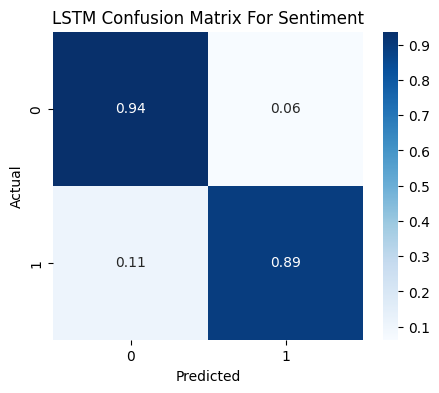

In [398]:

# Tạo và in ra ma trận nhầm lẫn
conf_mat = confusion_matrix(y_true, y_pred)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix For Sentiment')
plt.show()


# Dự đoán

In [399]:
def preprocess_and_embed(text, w2v_model):
    # Tiền xử lý văn bản
    normalized_text = normalize_text(text)
    tokenized_text = tokenizer(normalized_text)
    # Tạo vector nhúng cho văn bản
    vector = get_vector(tokenized_text, w2v_model)
    vector = vector.reshape(-1, 1, w2v_model.vector_size)
    return tokenized_text, vector

In [400]:
def predict_topic(sentence, w2v_model, lstm_model=None, rf_model=None, lr_model=None):
    # Tiền xử lý và tạo vector nhúng
    tokenized_text, embedding = preprocess_and_embed(sentence, w2v_model)

    if lstm_model:
        # Dự đoán topic bằng LSTM
        prediction = lstm_model.predict(embedding)
        topic_labels = ['lecturer', 'training_program', 'facility', 'others']
        predicted_topic = topic_labels[np.argmax(prediction)]
        return predicted_topic

    elif rf_model:
        # Dự đoán topic bằng Random Forest
        prediction = rf_model.predict([embedding.flatten()])
        topic_labels = ['lecturer', 'training_program', 'facility', 'others']
        predicted_topic = topic_labels[prediction[0]]
        return predicted_topic

    elif lr_model:
        # Dự đoán topic bằng Logistic Regression
        prediction = lr_model.predict([embedding.flatten()])
        topic_labels = ['lecturer', 'training_program', 'facility', 'others']
        predicted_topic = topic_labels[prediction[0]]
        return predicted_topic

def predict_sentiment(sentence, w2v_model, lstm_model=None, rf_model=None, lr_model=None):
    # Tiền xử lý và tạo vector nhúng
    tokenized_text, embedding = preprocess_and_embed(sentence, w2v_model)

    if lstm_model:
        # Dự đoán sentiment bằng LSTM
        prediction = lstm_model.predict(embedding)
        sentiment_labels = ['negative', 'positive']
        predicted_sentiment = sentiment_labels[np.argmax(prediction)]
        return predicted_sentiment

    elif rf_model:
        # Dự đoán sentiment bằng Random Forest
        prediction = rf_model.predict([embedding.flatten()])
        sentiment_labels = ['negative', 'positive']
        predicted_sentiment = sentiment_labels[prediction[0]]
        return predicted_sentiment

    elif lr_model:
        # Dự đoán sentiment bằng Logistic Regression
        prediction = lr_model.predict([embedding.flatten()])
        sentiment_labels = ['negative', 'positive']
        predicted_sentiment = sentiment_labels[prediction[0]]
        return predicted_sentiment


## Topic

In [401]:
text_to_predict = input("Nhập đoạn văn bản cần dự đoán: ")

Nhập đoạn văn bản cần dự đoán: bài hay


In [402]:
predicted_topic_lr = predict_topic(text_to_predict, w2v_model, lr_model=logistic_model_topic)
predicted_topic_lstm = predict_topic(text_to_predict, w2v_model, lstm_model=model_LSTM_topic)
predicted_topic_rf = predict_topic(text_to_predict, w2v_model, rf_model=classifier_topic)

print(f"Random Forest - Dự đoán Topic: {predicted_topic_rf}")
print(f"Logistic Regression - Dự đoán Topic: {predicted_topic_lr}")
print(f"LSTM - Dự đoán Topic: {predicted_topic_lstm}")

1/1 [==============================] - 0s 115ms/step
Random Forest - Dự đoán Topic: training_program
Logistic Regression - Dự đoán Topic: lecturer
LSTM - Dự đoán Topic: training_program


## Sentiment

In [403]:
predicted_sentiment_rf = predict_sentiment(text_to_predict, w2v_model, rf_model=classifier_sentiment)
predicted_sentiment_lr = predict_sentiment(text_to_predict, w2v_model, lr_model=logistic_model_sentiment)
predicted_sentiment_lstm = predict_sentiment(text_to_predict, w2v_model, lstm_model=model_LSTM_sentiment)

print(f"Random Forest - Dự đoán Sentiment: {predicted_sentiment_rf}")
print(f"Logistic Regression - Dự đoán Sentiment: {predicted_sentiment_lr}")
print(f"LSTM - Dự đoán Sentiment: {predicted_sentiment_lstm}")

1/1 [==============================] - 0s 156ms/step
Random Forest - Dự đoán Sentiment: positive
Logistic Regression - Dự đoán Sentiment: positive
LSTM - Dự đoán Sentiment: positive
